## Honda

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import sys
from matplotlib import cm, colors
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable

plt.rcParams['font.size'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

In [3]:
sys.path.append('C:\\Users\\Bruger\\AppStat2021\\External_Functions')
import Clotilde_external_functions as cef

In [21]:
r_theta = r'$\theta$'
r_numu = r'$\nu_{\mu}$'

In [6]:
# cos intervals
cos_values = np.round(np.arange(1, -1.1, -0.1), 2)
cos_strings = []

for i in range(len(cos_values)-1):
    string = f'{cos_values[i+1]} - {cos_values[i]}'
    cos_strings.append(string)

In [7]:
# Loading the data
len_file = 2060
len_subfile = 103
footer_skip_lines = len_file - np.arange(len_subfile, len_file+1, len_subfile)
header_skip_lines = np.arange(2, len_file-len_subfile+3, len_subfile)

# Same energy array for all angles
energy_sp = np.genfromtxt('2.6_sp_solmax.d', skip_header = header_skip_lines[0], 
                          skip_footer = footer_skip_lines[0])[:, 0]

# Matrix with all fluxes
numu_sp_matrix = np.zeros((len(footer_skip_lines), len_subfile-2))

for i in range(len(footer_skip_lines)):
    numu_sp = np.genfromtxt('2.6_sp_solmax.d', skip_header = header_skip_lines[i], 
                            skip_footer = footer_skip_lines[i])[:, 1]
    numu_sp_matrix[i,:] = numu_sp

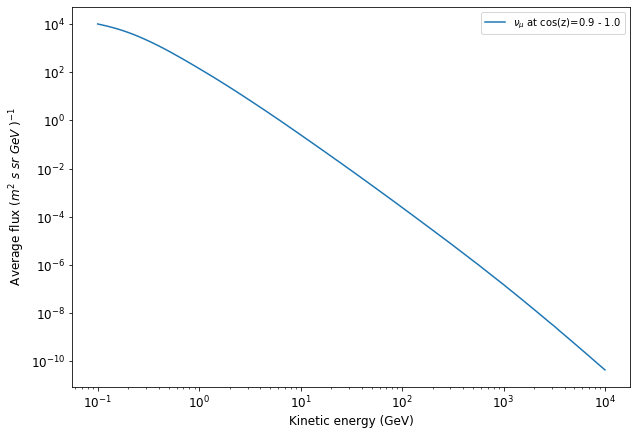

In [8]:
# Plot for cos(z) = 0.9 - 1.0

fig, ax = plt.subplots(figsize=(10,7))
r_phi = r'$\phi_{Az}$'
ax.loglog(energy_sp, numu_sp_matrix[0,:], label=f'{r_numu} at cos(z)={cos_strings[0]}')
ax.set_xlabel('Kinetic energy (GeV)', fontsize=12)
ax.set_ylabel(r' Average flux ($m^2$ $s$ $sr$ $GeV$ $)^{-1}$', fontsize=12)
ax.legend()

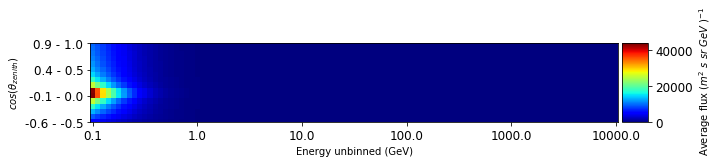

In [9]:
# UNBINNED

fig, ax = plt.subplots(figsize=(10,10))

im = ax.imshow(numu_sp_matrix, cmap='jet')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

cbar = plt.colorbar(im, cax=cax)
ax.set_xlabel('Energy unbinned (GeV)')
ax.set_ylabel(r'$cos(\theta_{zenith})$')
ax.set_xticks([0, 20, 40, 60, 80, 100])
ax.set_xticklabels([energy_sp[0], energy_sp[20], energy_sp[40], energy_sp[60],
                    energy_sp[80], energy_sp[100]])
ax.set_yticks([0,5,10,15])
ax.set_yticklabels([cos_strings[0], cos_strings[5], cos_strings[10], cos_strings[15]]);
cbar.set_label(r' Average flux ($m^2$ $s$ $sr$ $GeV$ $)^{-1}$');


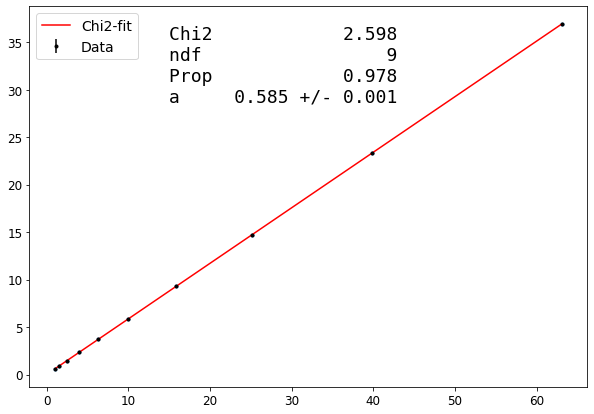

In [64]:
# Plot and fit of binwidth vs. Emin

numu_cc = np.genfromtxt('numu_cc.csv', skip_header = 1, delimiter =',')
energy_min_cc = numu_cc[:,0]
energy_max_cc = numu_cc[:,1]

energy_binwidths = energy_max_cc - energy_min_cc
fig, ax = plt.subplots(figsize=(10,7))
ax.plot(energy_min_cc, energy_binwidths, '.')
x = np.arange(0.1, 10000, 1)
yerr = np.ones(10)*0.05

def e_bins_fit(x, a):
    return a*x
    
_, _, fit_val, _ = cef.chi_squared_plot(ax, e_bins_fit, energy_min_cc, energy_binwidths, yerr, ['a'], [0.5], loc_dic=(0.25, 0.95))

In [90]:
# Find rest of Emin

def e_bins(e_min):
        return(fit_val[0]*e_min)

e_min = [0.1]

while e_min[-1] < energy_sp[-1]:
    bin_width = e_bins(e_min[-1])
    new_bin_start = e_min[-1] + bin_width
    if new_bin_start > energy_sp[-1]:
        break
    e_min.append(new_bin_start)
    
print(e_min)

[0.1, 0.15850977036493924, 0.2512534730114577, 0.3982613031043961, 0.6312830770031929, 1.0006453557104835, 1.5861206555041167, 2.5141562087504443, 3.9851832331061914, 6.316904791418684, 10.0129112790496, 15.871442675266621, 25.157787338168088, 39.877550938629994, 63.20981441998407, 100.193731685221, 158.81685401430715, 251.74023059889902, 399.03286143848334, 632.5060723467861, 1002.5839228211871, 1589.1934737796632, 2519.026925942745, 3992.9037957428327, 6329.142637524907]


In [125]:
# Find index of Emin

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

e_min_true = np.zeros(len(e_min))
e_min_arg = np.zeros(len(e_min))

for i in range(len(e_min)):
    true_min = find_nearest(energy_sp, e_min[i])
    e_min_true[i] = true_min
    e_min_arg[i] = np.where( energy_sp == e_min_true[i])[0][0]
    
e_min_arg = e_min_arg.astype(int)
print(e_min_arg)

# OMG... it's just every 4th column

[ 0  4  8 12 16 20 24 28 32 36 40 44 48 52 56 60 64 68 72 76 80 84 88 92
 96]


In [150]:
binned_numu_sp_matrix = np.zeros((len(footer_skip_lines), len(e_min)))

# Summing every 4th column in numu_sp_matrix to get the binned matrix
for i in range(len(e_min_arg)):
    if e_min_arg[i]+3 < e_min_arg[-1]:
        columns = numu_sp_matrix[:,e_min_arg[i]:e_min_arg[i]+4]
    else:
        columns = numu_sp_matrix[:,e_min_arg[i]:-1]
    sum_column = np.sum(columns, axis = 1)
    binned_numu_sp_matrix[:,i] = sum_column

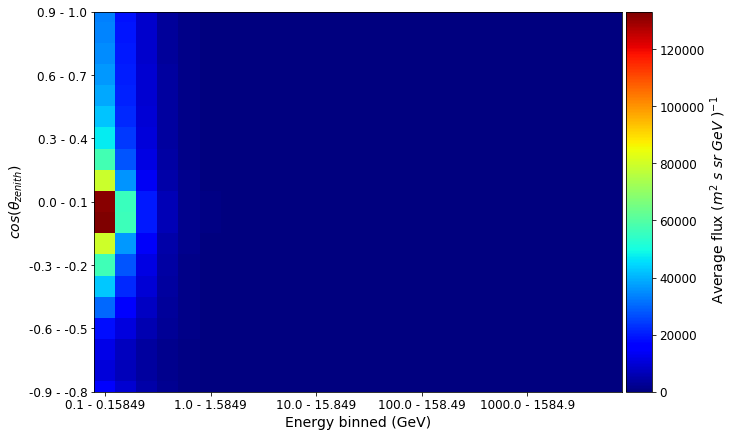

In [169]:
# BINNED PLOT
xticks = np.arange(0, 21, 5)
yticks = np.arange(0, 21, 3)

energy_strings = []

for i in range(len(e_min_true)-1):
    string = f'{e_min_true[i]} - {e_min_true[i+1]}'
    energy_strings.append(string)

xlabels = []
ylabels = []

for i in range(len(xticks)):
    label_x = energy_strings[xticks[i]]
    xlabels.append(label_x)
    
for i in range(len(yticks)):
    label_y = cos_strings[yticks[i]]
    ylabels.append(label_y)

fig, ax = plt.subplots(figsize=(10,10))

im = ax.imshow(binned_numu_sp_matrix, cmap='jet') 
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

cbar = plt.colorbar(im, cax=cax)
ax.set_xlabel('Energy binned (GeV)')
ax.set_ylabel(r'$cos(\theta_{zenith})$')
ax.set_xticks(xticks)
ax.set_xticklabels(xlabels)
ax.set_yticks(yticks)
ax.set_yticklabels(ylabels);
cbar.set_label(r' Average flux ($m^2$ $s$ $sr$ $GeV$ $)^{-1}$');

# Difference between this and 2d histogram?
# Different from MCEq_1d

In [231]:
# Plot only for energy range in numu_cc.csv

numu_sp_matrix_cropped = numu_sp_matrix[:, np.where( energy_sp == 1)[0][0] : np.where( energy_sp == 100)[0][0]]
binned_numu_sp_matrix_cropped = np.zeros((len(footer_skip_lines), len(energy_min_cc)))

for i in range(len(energy_min_cc)):
    binned_column = np.sum(numu_sp_matrix_cropped[:, i:i+4], axis = 1)
    binned_numu_sp_matrix_cropped[:,i] = binned_column

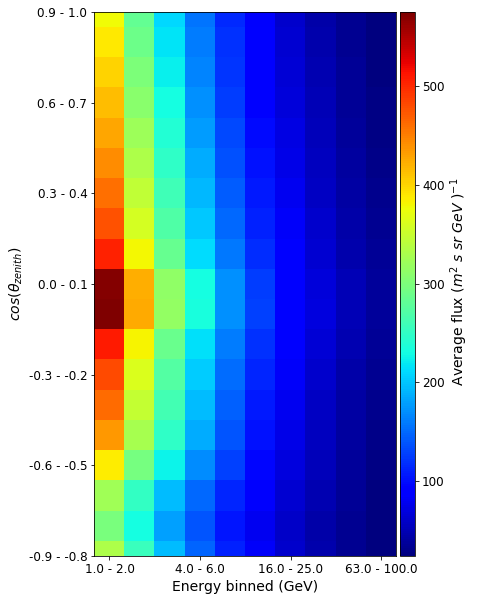

In [230]:
xticks_cropped = np.arange(0, 11, 3)
energy_strings_cropped = []

for i in range(len(energy_min_cc)):
    if i in xticks_cropped:
        string = f'{np.round(energy_min_cc[i],0)} - {np.round(energy_max_cc[i],0)}'
        energy_strings_cropped.append(string)

fig, ax = plt.subplots(figsize=(15,10))

im = ax.imshow(binned_numu_sp_matrix_cropped, cmap='jet') 
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

cbar = plt.colorbar(im, cax=cax)
ax.set_xlabel('Energy binned (GeV)')
ax.set_ylabel(r'$cos(\theta_{zenith})$')
ax.set_xticks(xticks_cropped)
ax.set_xticklabels(energy_strings_cropped)
ax.set_yticks(yticks)
ax.set_yticklabels(ylabels);
cbar.set_label(r' Average flux ($m^2$ $s$ $sr$ $GeV$ $)^{-1}$');